## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
import tf2_ros
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped

import sys

from utils_notebooks import *
import cv2
import os


In [9]:

rospy.init_node("recognition")


In [10]:


listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()

rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [11]:
rgbd = RGBD()

In [12]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')


In [13]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [7]:
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
navclient.wait_for_server()

def move_base_actionlib(pose):
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result()

    # print result of navigation
    action_state = navclient.get_state()
    if action_state == GoalStatus.SUCCEEDED:
        rospy.loginfo("Navigation Succeeded.")

In [7]:
goal_x , goal_y,goal_yaw= 1.14,0.3,1.57
 
# fill ROS message
pose = PoseStamped()
pose.header.stamp = rospy.Time.now()
pose.header.frame_id = "map"
pose.pose.position = Point(goal_x, goal_y, 0)
quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
pose.pose.orientation = Quaternion(*quat)

#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

True

[WARN] [1634057260.528846]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.
[WARN] [1634057260.548188]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.
[WARN] [1634057352.874337]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [11]:
move_base_actionlib(pose)

[INFO] [1633643448.139901, 106.701000]: Navigation Succeeded.


In [9]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()
### GET TF (REFERENCE FRAME FOR XTION SENSOR )
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

([-0.9520835915516259, -0.5885594028205342, 0.9615243385484805],
 (-4.896587711735749e-12, 0.7757275795962041, 2.5896508792482553))

In [10]:
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)


trans, np.rad2deg(euler)

([-0.956997679756887, -0.5895664511958061, 0.9606170234484436],
 array([-2.80549904e-10,  4.49948299e+01,  1.48361901e+02]))

In [11]:
def cart2spher(x,y,z):
    ro= np.sqrt(x**2+y**2+z**2)
    th=np.arctan2(y,x)
    phi=np.arctan2((np.sqrt(x**2+y**2)),z)
    return np.asarray((ro,th,phi))
def spher2cart(ro,th,phi):
    x= ro * np.cos(th)* np.sin(phi)
    y= ro * np.sin(th)* np.sin(phi)
    z= ro*  np.cos(th)
    return np.asarray((x,y,z))

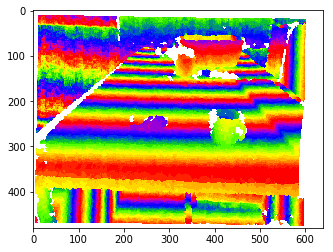

In [42]:
# ポイントクラウドを取得します Get point cloud information
points_data = rgbd.get_points()
# ポイントクラウドの深度情報を表示してみます Display the depth value of the point cloud information
plt.imshow(points_data['z'], cmap='prism')

In [43]:
px_y,px_x=-1,-200
P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-1,200
P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-150,320
P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=1,320
P4= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
P1,P2,P3 , P4

(array([nan, nan, nan], dtype=float32),
 array([nan, nan, nan], dtype=float32),
 array([-3.8101323e-04,  9.7872868e-02,  5.4500002e-01], dtype=float32),
 array([nan, nan, nan], dtype=float32))

In [18]:
V1 =P1 - P2
V2= P3-P2
nx,ny,nz=np.cross(V2,V1)
print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
print ('cartesian Normal floor',nx,ny,nz)
#plane angle to be found is same slope as the camera 

np.rad2deg(euler)[1]

#OR ELSE

('look at the phi angle  in normal vector', -45.08481990262674)
('cartesian Normal floor', 0.00037779126, 0.08937061, 0.08963641)


45.103658862208675

In [19]:
#check if P4  its in floor plane
#normal vector = np.cross(V2,V1)
##vectors from known floor points
##P0= P1
## 0 = \vec{n} \dot \vec{P_0P}
np.dot(np.asarray((nx,ny,nz,)),P4-P1)
## if not 0 (or almost )

-0.050631195

In [20]:




ind=0
quat=rot


In [21]:
x,y,z=P1
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P1',"head_rgbd_sensor_link")
x,y,z=P2
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P2',"head_rgbd_sensor_link")
x,y,z=P3
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P3',"head_rgbd_sensor_link")
x,y,z=P4
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P4',"head_rgbd_sensor_link")
rospy.sleep(.4)

In [22]:

trans , rot = listener.lookupTransform('/map', '/P1', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 1 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P2', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 2 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P3', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 3 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P4', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 4 wrt map',trans, np.rad2deg(euler))
gazebo_2_world

('point 1 wrt map', [1.3174893946470188, 0.7938305161437357, 0.0019558934039957117], array([-179.83905394,   -0.20874425,  -90.09384009]))
('point 2 wrt map', [0.90776395015732, 0.7961350620513006, 0.0007328129019489315], array([-179.83905394,   -0.20874425,  -90.09384009]))
('point 3 wrt map', [1.1143277861383252, 1.1039050030572533, 0.001238659115045615], array([-179.83905394,   -0.20874425,  -90.09384009]))
('point 4 wrt map', [1.1176786222656285, 1.8133028545262624, 0.4009967509061312], array([-179.83905394,   -0.20874425,  -90.09384009]))


<function utils_notebooks.gazebo_2_world>

In [23]:
image_data=rgbd.get_image()
mask=np.zeros((image_data.shape))
plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))


In [24]:
mask[:,:,0]=points_data['x'] - P1[0]
mask[:,:,1]=points_data['y'] - P1[1]
mask[:,:,2]=points_data['z'] - P1[2]

In [25]:
for i in range (image_data.shape[0]):
    for j in range (image_data.shape[1]):
        plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])

In [26]:
plane_mask=plane_mask-np.min(plane_mask)
plane_mask=plane_mask*256/np.max(plane_mask)
plane_mask.shape

(480, 640)

In [27]:
plane_mask.astype('uint8')
plane_mask.shape

(480, 640)

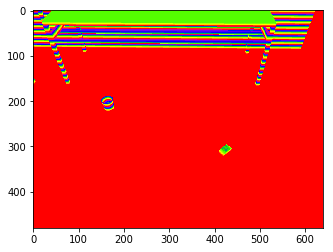

In [28]:
plt.imshow(plane_mask , cmap='prism')

In [29]:
plane_mask[200,1], plane_mask[-1,1],plane_mask[1,1]

(0.0009947224820479345, 0.0011032782057309955, 175.81719574176807)

In [30]:
plane_mask.shape


(480, 640)

In [31]:
ret,thresh = cv2.threshold(plane_mask,3,255,0)


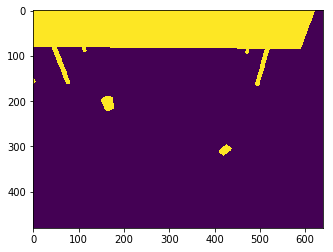

In [32]:
#FLOOR MASK
plt.imshow(thresh) 

('contour', 0, 'area', 377.0)
('contour', 1, 'area', 680.5)


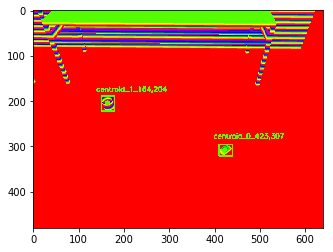

In [33]:
cv2_img=plane_mask.astype('uint8')
img=plane_mask.astype('uint8')
contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    
    if area > 200 and area < 50000 :
        print('contour',i,'area',area)
        
        boundRect = cv2.boundingRect(contour)
        #just for drawing rect, dont waste too much time on this
        img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
        # calculate moments for each contour
        xyz=[]
        
        
        for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
            for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
        xyz=np.asarray(xyz)
        cent=xyz.mean(axis=0)
        cents.append(cent)
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
        cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
cents=np.asarray(cents)
plt.imshow(img ,cmap='prism')

In [34]:
x,y,z=cents[np.argmin(np.linalg.norm((cents-trans),axis=1))]
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object',"head_rgbd_sensor_link")
rospy.sleep(.2)

In [31]:
###Run again the appropriate blocks to try to look for legos on the way


###CAn you navigate through?

### Can we pick em up?


#PLEASE TRY THINGS HERE

In [32]:
cent_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object',rospy.Time(0))
cent_euler=tf.transformations.euler_from_quaternion(cent_quat)


In [13]:
whole_body = moveit_commander.MoveGroupCommander('whole_body')
whole_body.allow_replanning(True)
whole_body.set_workspace([-3.0, -3.0, 3.0, 3.0])

In [44]:
p = PoseStamped()
p.header.frame_id = "hand_palm_link"#'head_rgbd_sensor_link'   ## ODOM NOR MAP SEEM TO WORK; RRT CONNECT?
p.pose.position.x = cent_map[0]
p.pose.position.y = cent_map[1]
p.pose.position.z = cent_map[2]+.5
p.pose.orientation.w = 1
whole_body.set_joint_value_target(p)
whole_body.go()




MoveItCommanderException: Error setting joint target. Is the IK solver functional?

In [38]:
p=[0.033749214744071214,
 -2.1204421063180217,
 -1.3982377978814715,
 -1.7296544561013807,
 2.135675364707808,
 0.0]#whole_body.get_current_pose()

arm.set_joint_value_target(p)
arm.go()


True

In [39]:
arm.set_named_target('neutral')
arm.go()
head.set_named_target('neutral')
head.go()

True

In [ ]:
scene = moveit_commander.PlanningSceneInterface()

In [ ]:
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)
        

In [ ]:
p_s = moveit_msgs.msg.PlanningScene()


In [ ]:
p_s.is_diff = True
color = moveit_msgs.msg.ObjectColor()
color.id = "floor"
color.color.g = 0.6
color.color.a = 0.9
p_s.object_colors.append(color)
scene_pub.publish(p_s)

In [ ]:
p = PoseStamped()
p.header.frame_id = '/map'
p.pose.position.x =cent_map[0]-.1
p.pose.position.y = cent_map[1]-.1
p.pose.position.z = cent_map[2]
p.pose.orientation.w = 1.0
scene.add_box('floor', p,(1,1,.02))

In [ ]:
whole_body.set_support_surface_name('floor')

In [ ]:
p = PoseStamped()
p.header.frame_id = '/map'
p.pose.position.x =cent_map[0]
p.pose.position.y = cent_map[1]
p.pose.position.z = cent_map[2]
p.pose.orientation.w = 1.0
scene.add_box('CLOSEST OBJ', p,(.1,.1,.05))

In [ ]:
????

In [ ]:
scene.remove_world_object()

In [ ]:
w


In [ ]:
### GO TO TAKESHI NEUTRAL
arm.set_named_target("go")
arm.go()
head.set_named_target("neutral")
head.go()

In [ ]:
p = PoseStamped()
p.header.frame_id = '/odom'
p.pose.position.x =cent_map[0]
p.pose.position.y = cent_map[1]
p.pose.position.z = cent_map[2]+.4
p.pose.orientation.w = 1.0

In [ ]:
whole_body.set_goal_tolerance(.1)

In [ ]:
whole_body.clear_pose_targets()

In [ ]:
whole_body.set_pose_target(p)


In [ ]:
whole_body.plan()

In [11]:
arm.get_current_joint_values()

[0.41613230701476367,
 -1.67179285342859,
 -0.027646503414453516,
 0.020466550081086332,
 0.22366680133038308,
 0.0]

In [21]:
p=whole_body.get_current_pose()
p.pose.position.x+=.2
p.pose.position.z-=.2
whole_body.set_pose_target(p)
whole_body.go()

False

In [17]:
##KNOWN LOCATIONS
kl_mess1= [1.04,0.3,90]
kl_tray=  [ 2.318411366833172, 0.09283744344925589,-90]
kl_box1=  [-0.04168256822546347, 2.427268271720426, -90]
### ARM 
arm_grasp_from_above=[0.19263830140116414,
 -2.2668981568652917,
 -0.007358947463759424,
 -0.9939144210462025,
 -0.17365421548386273,
 0.0]
arm_grasp_from_above_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 -1.5952436225825641,
 0.22362492457833927,
 0.0]


arm_grasp_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 0.0,
 0.22362492457833927,
 0.0]


arm_grasp_floor=[-1.5151551103007697e-05,
 -2.4,
 -0.2620865401925543,
 0.7019536624449207,
 0.20120924571306453,
 0.0]
arm_train_pose=[0.033749214744071214,
 -2.1204421063180217,
 -1.3982377978814715,
 -1.7296544561013807,
 2.135675364707808,
 0.0]

arm_ready_to_place=[0.03999320441056991,
 -0.4729690540086997,
 0.19361475012179108,
 -1.5269847787383313,
 -0.009753879176134461,
 0.0]

In [18]:
arm.set_joint_value_target(arm_grasp_table)
arm.go()

True

In [22]:
def seg_pca(): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 2000 and area < 50000 :


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                    if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                        'reject point'
                    else:
                        xyz.append(aux)
            
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            points.append(xyz)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(im4)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points))



def static_tf_publish(cents, quaternions=[]):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        print quats
    else:
        quats=np.asarray(quaternions)
        print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            static_transformStamped.child_frame_id = "static"+str(i)
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


            tf_static_broadcaster.sendTransform(static_transformStamped)
    return True


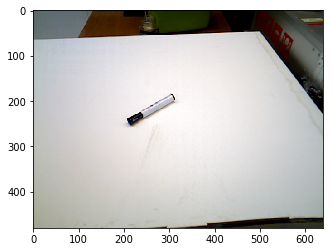

In [36]:
plt.imshow(rgbd.get_image())

('cX,cY', 106, 436)
('cX,cY', 351, 19)
('cX,cY', 179, 25)


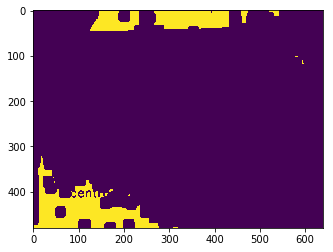

In [37]:
cents, xyz = seg_pca()

In [38]:
from sklearn.decomposition import PCA

In [39]:
import math as m
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
quats=pca_xyz(xyz)



from sklearn.decomposition import PCA
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
quats=pca_xyz(xyz)

#FIND PCA OF EACH OBJECT



In [40]:
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
quats=pca_xyz(xyz)

In [41]:
static_tf_publish(cents,quats)

[[ 0.14651366  0.0675195   0.40592464  0.89955547]
 [-0.17357079  0.31218274 -0.78139312  0.51170295]
 [-0.21986499 -0.0989131   0.41782236  0.87595665]]


NameError: global name 'rot' is not defined

[WARN] [1634060491.477790]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.
[WARN] [1634060491.657469]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


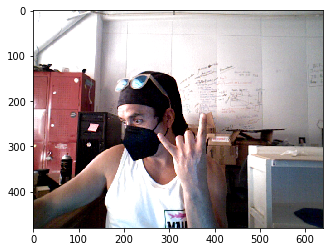

In [11]:
plt.imshow(rgbd.get_image())

In [13]:
arm = moveit_commander.MoveGroupCommander('arm')


RuntimeError: Unable to connect to move_group action server 'move_group' within allotted time (35s)

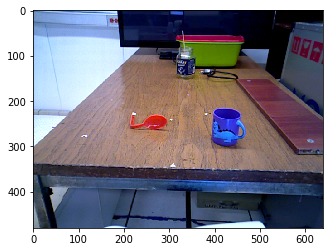

In [36]:
plt.imshow(rgbd.get_image())


In [14]:
arm

In [15]:
arm.get_active_joints()

['arm_lift_joint',
 'arm_flex_joint',
 'arm_roll_joint',
 'wrist_flex_joint',
 'wrist_roll_joint',
 'wrist_ft_sensor_frame_joint']

In [24]:
a=arm.get_current_joint_values()
a[0]-=.1
arm.set_joint_value_target(a)

In [25]:
arm.go()

True

In [21]:
head.set_named_target('neutral')
head.go()

True

In [32]:
def move_base_vel(vx, vy, vw):
    u"""台車を速度制御する関数

    引数:
        vx (float): 直進方向の速度指令値 [m/s]（前進が正、後進が負）
        vy (float): 横方向の速度指令値 [m/s]（左が正、右が負）
        vw (float): 回転方向の速度指令値 [deg/s]（左回転が正、右回転が負）

    """

    # 速度指令値をセットします
    twist = Twist()
    twist.linear.x = vx
    twist.linear.y = vy
    twist.angular.z = vw / 180.0 * math.pi  # 「度」から「ラジアン」に変換します
    base_vel_pub.publish(twist)

In [58]:
move_base_vel(0,0,-40)

In [53]:
import math

In [31]:


base_vel_pub = rospy.Publisher('/hsrb/command_velocity', Twist, queue_size=1)


In [35]:
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-30)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()

True

In [14]:
def segment_table2(chan):
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,chan]

    ret,thresh = cv2.threshold(image_data[:,:,2],240,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 200 and area < 50000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img)
    return (cents)



('contour', 387, 'area', 21914.0)
(221, 124, 206, 188)
('cX,cY', 328, 216)


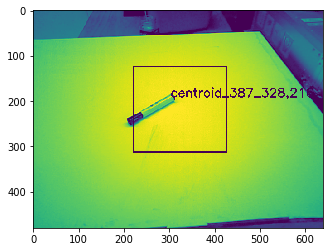

In [30]:
cents =segment_table2(1)

In [28]:
static_tf_publish(cents)

[[0. 0. 0. 1.]]
nan


True

In [29]:
cents

array([[nan, nan, nan]], dtype=float32)